# Numerical Results for the Gene Expression Network

### Compare Gillespie simulation with mass action kinetics and Plefka approximation

In [1]:
using Pkg
cd(@__DIR__)
Pkg.activate("../../")
using CRN
using PyPlot
PyPlot.PyDict(PyPlot.matplotlib."rcParams")["font.size"] = 16

 Activating environment at `~/ownCloud/Master/Simulations/CRN/Project.toml`
┌ Info: Precompiling CRN [da75a55d-9cc8-480a-9f60-a17664246748]
└ @ Base loading.jl:1260


16

In [24]:
# Parameters
num_species = 3     # number of species
num_int = 3         # number of interaction reaction

# Reaction constants
k1 = [0, 0, 0]      # Creation
k2 = [0, 1, 0]    # Annihiliation
k3 = [0.5, 0.5, 0.5]    # Interaction
k = [k1, k2, k3]

# Stoichiometric
s_i = zeros(Int, num_int, num_species)
r_i = copy(s_i)
s_i[1,:] = [1 1 0]
r_i[1,:] = [1 0 0]
s_i[2,:] = [0 0 1]
r_i[2,:] = [1 1 0]
s_i[3,:] = [1 1 0]
r_i[3,:] = [0 0 1]

# Times
t_init = 0.0        # Start time
t_final = 10.0       # End time
delta_t = 0.01      # time step
tspan = collect(t_init:delta_t:t_final)

# Initial condition
x0 = [3., 1., 1.] #k1 ./ k2

3-element Array{Float64,1}:
 3.0
 1.0
 1.0

## Gillespie Simulation

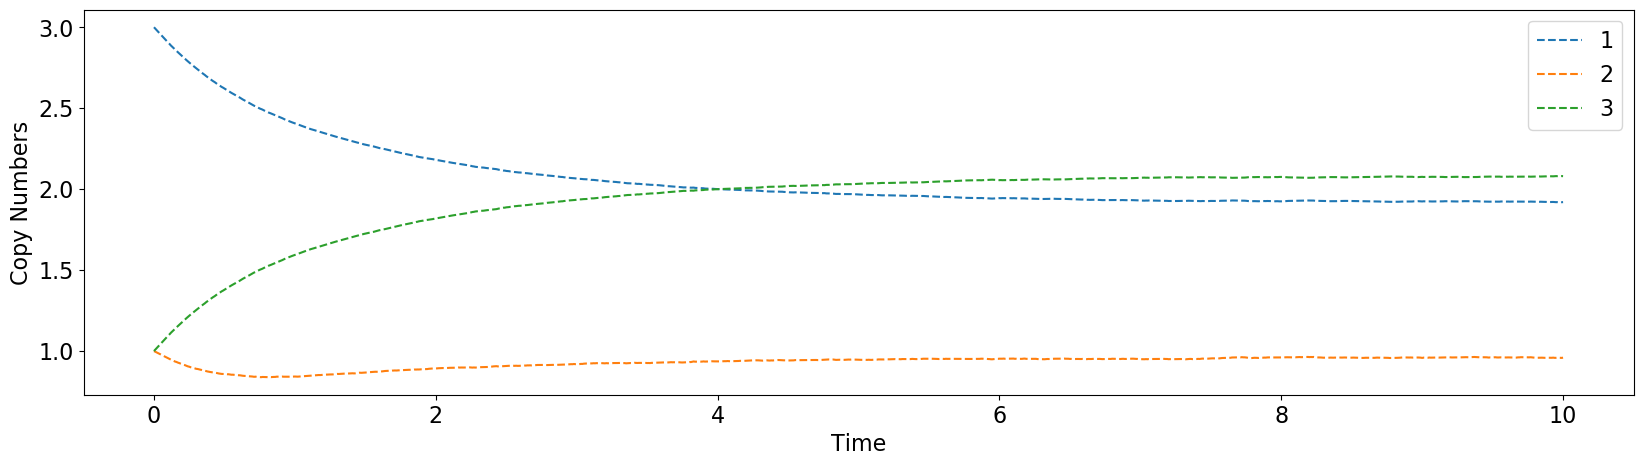

PyObject Text(32.999999999999986, 0.5, 'Copy Numbers')

In [25]:
N = 100000   # Repititions
res_gil = gillespie_avg_v2(x0, k, s_i, r_i, tspan, N, poisson=false)
plot_trajectories(res_gil)

## Mass Action Kinetics

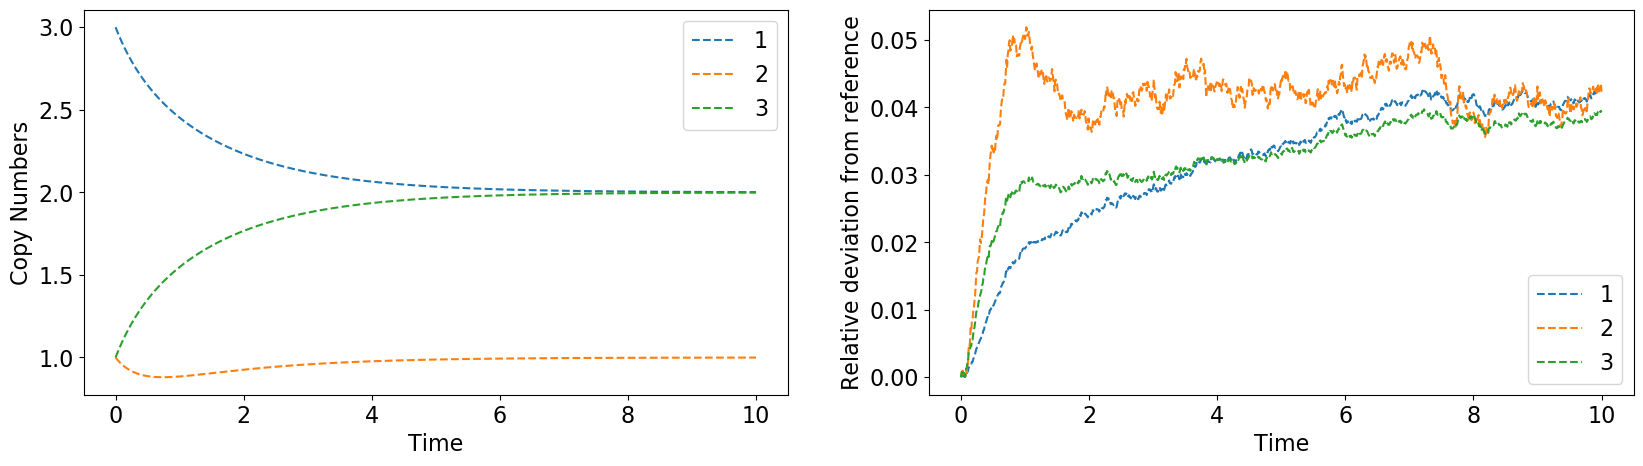

PyObject Text(864.3295454545454, 0.5, 'Relative deviation from reference')

In [26]:
function f_massAction!(du,u,k,t)
    du[1] = k1[1] - k2[1]*u[1] - k3[2]*u[1]*u[2] + k3[3]*u[3]
    du[2] = k1[2] - k2[2]*u[2] + k3[1]*u[1] - k3[2]*u[1]*u[2] + k3[3]*u[3]
    du[3] = k1[3] - k2[3]*u[3] + k3[2]*u[1]*u[2] - k3[3]*u[3]
end

ts = (tspan[1], tspan[end])
res_ma = ode_solver(f_massAction!, k, ts, delta_t, x0)
plot_trajectories_and_deviation(res_ma, res_gil)

## Plefka with linear O.P. and power α¹ 

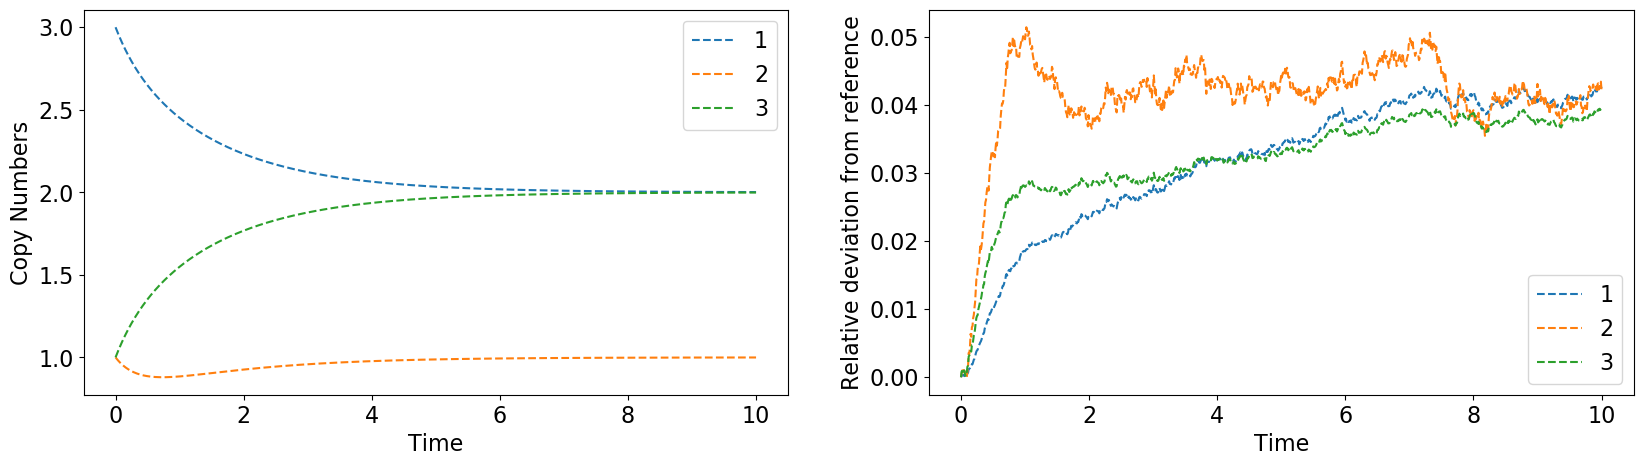

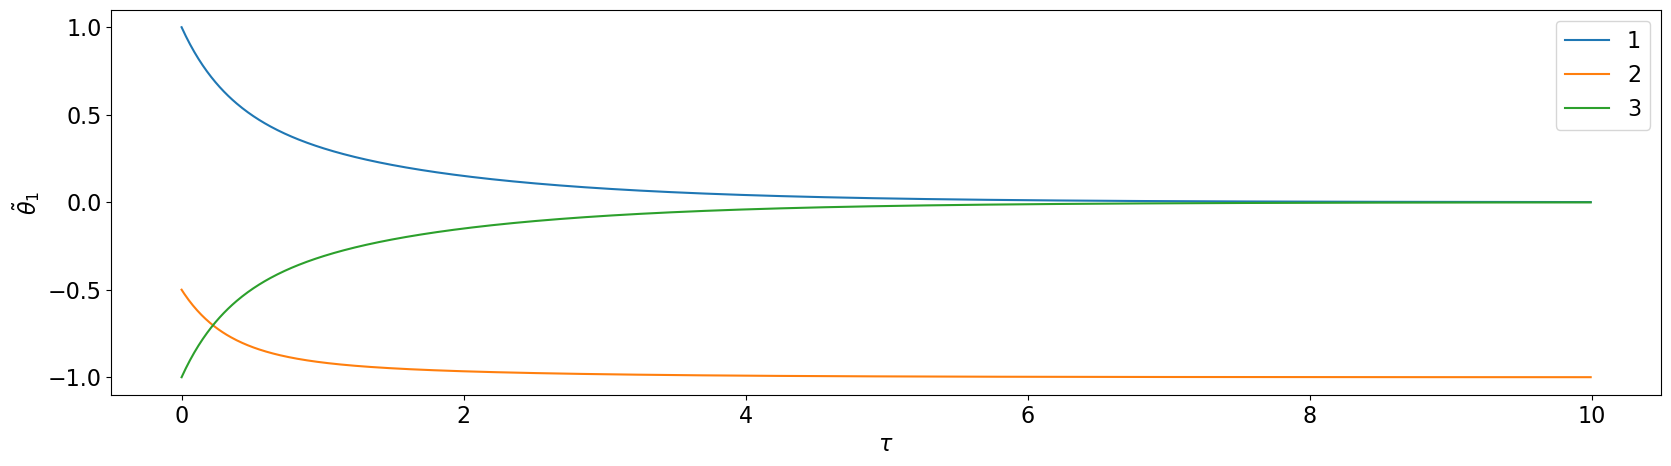

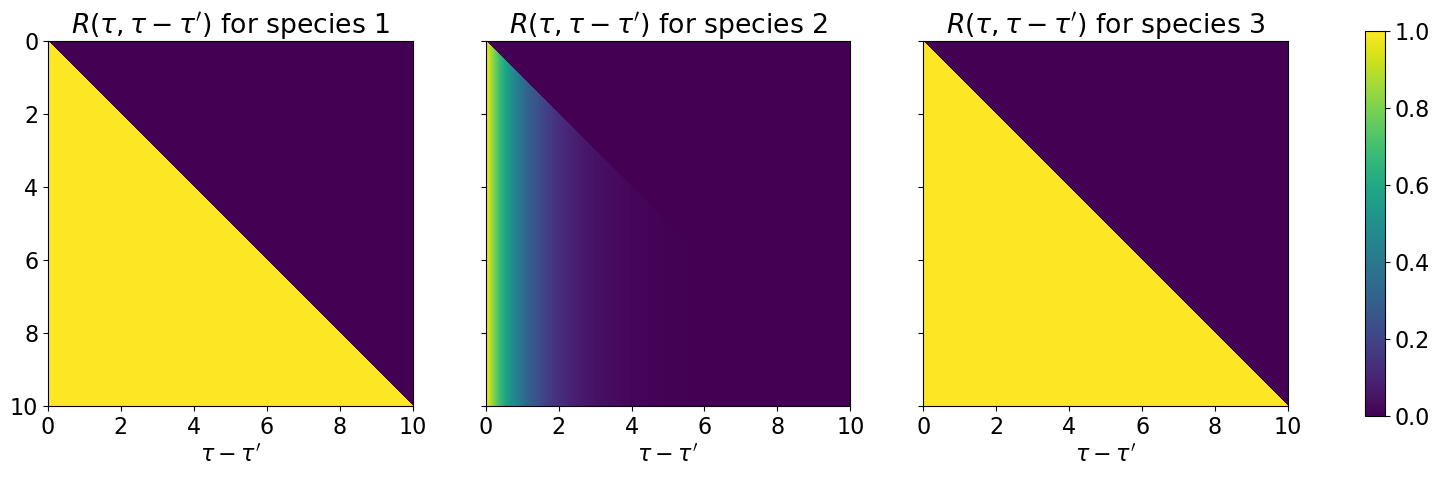

In [27]:
plf_sim_11 = Plefka(1.0, 1, "linear") # α, alphaOrder, orderParameter
res_plf_11 = euler_step(x0, k, tspan, plf_sim_11; ABC=false)
plot_trajectories_and_deviation(res_plf_11[1], res_gil)
plot_hatTheta(plf_sim_11, res_plf_11[3])
plot_responses(res_plf_11[2])

## Plefka with linear O.P. and power α²

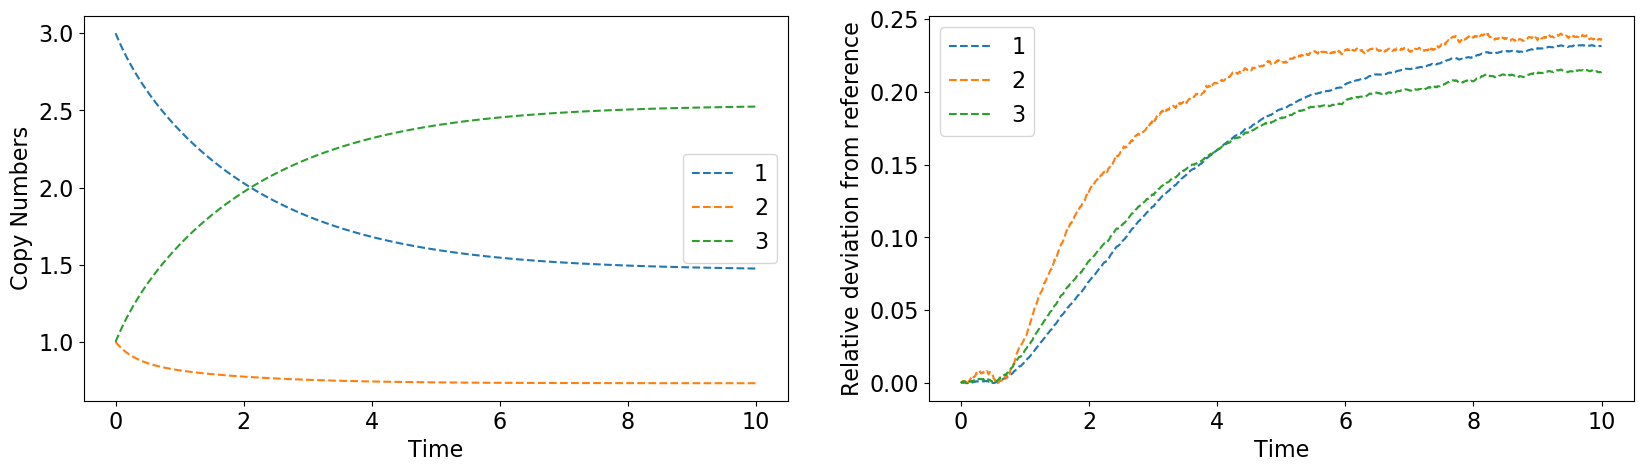

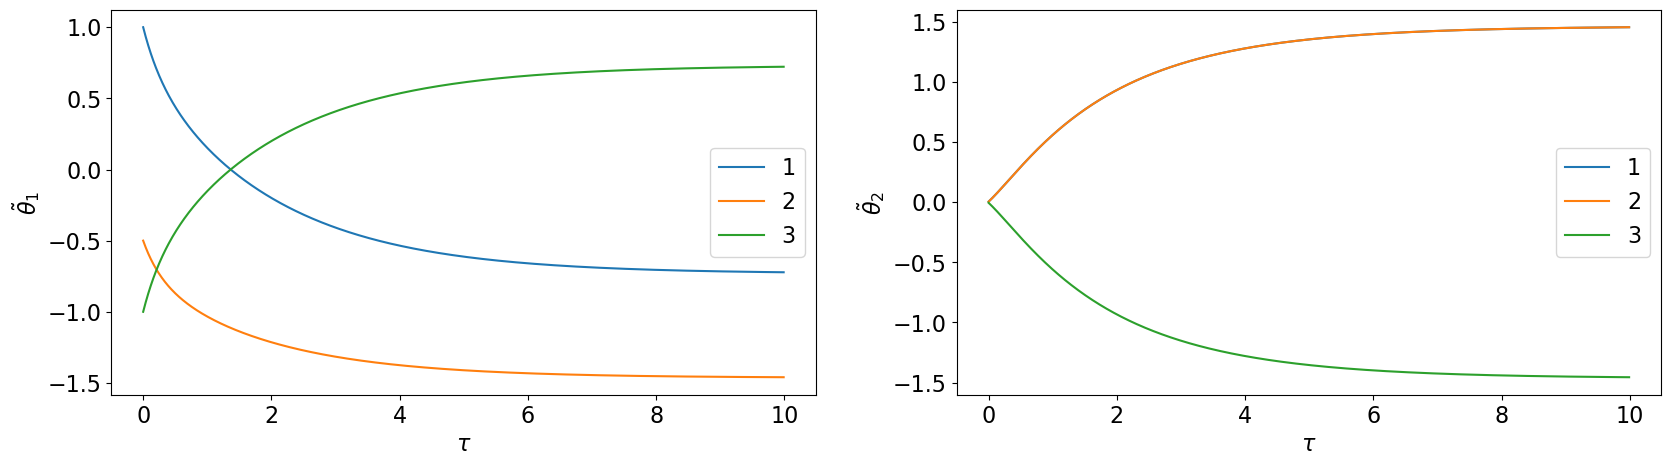

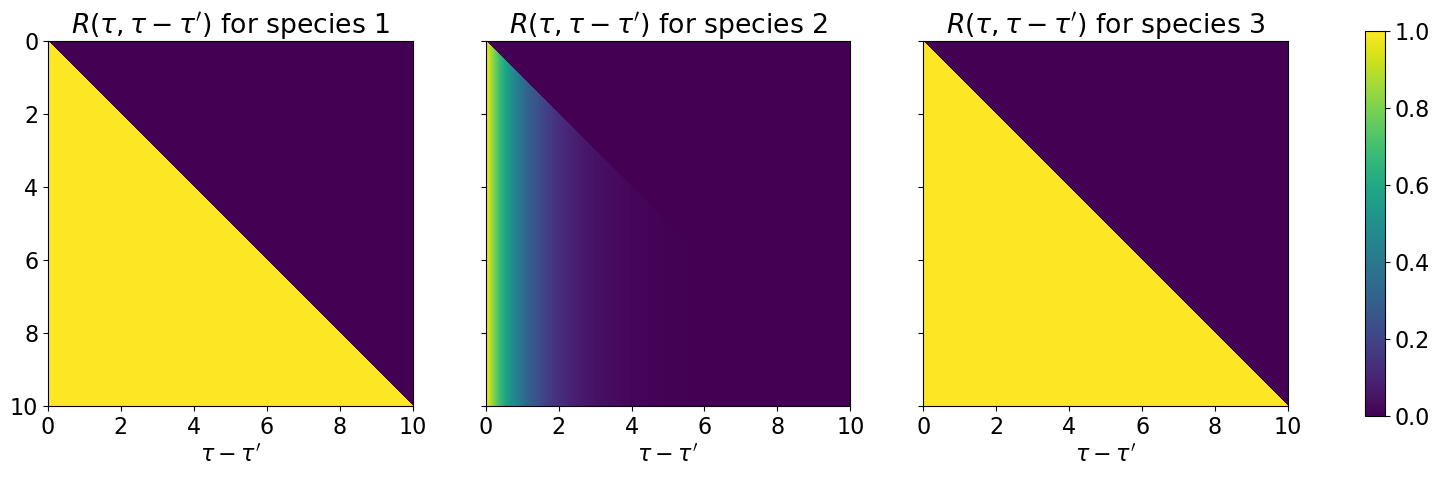

In [28]:
plf_sim_21 = Plefka(1.0, 2, "linear") # α, alphaOrder, orderParameter
res_plf_21 = euler_step(x0, k, tspan, plf_sim_21; ABC=false)
plot_trajectories_and_deviation(res_plf_21[1], res_gil)
plot_hatTheta(plf_sim_21, res_plf_21[3])
plot_responses(res_plf_21[2])

## Plefka with quad O.P. and power α¹ 

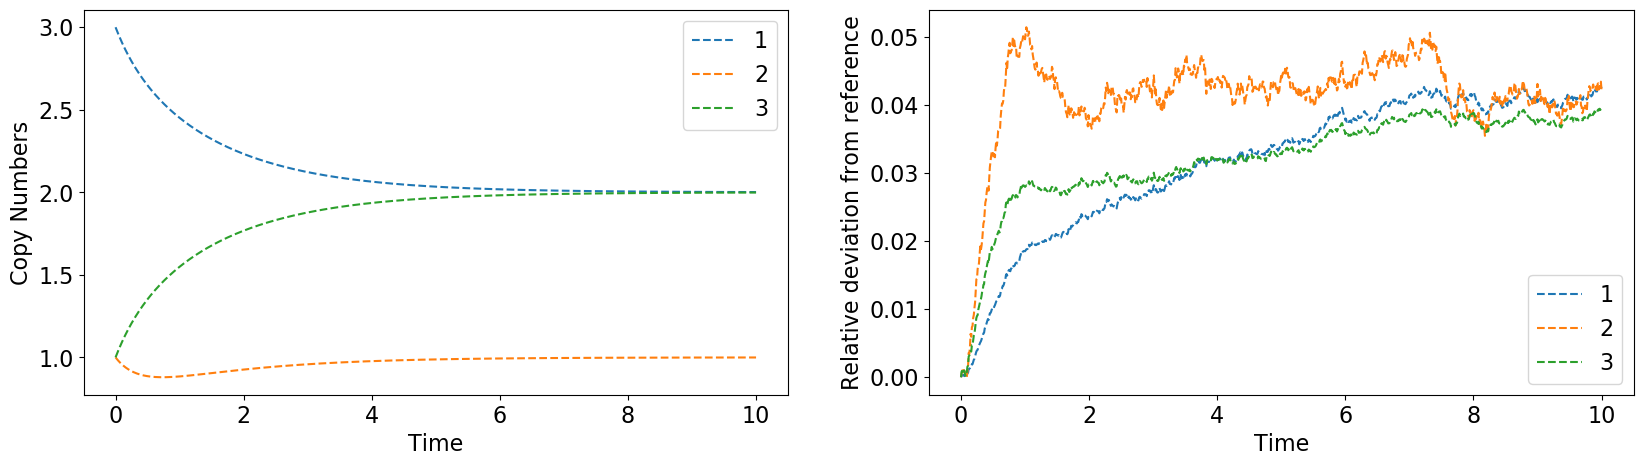

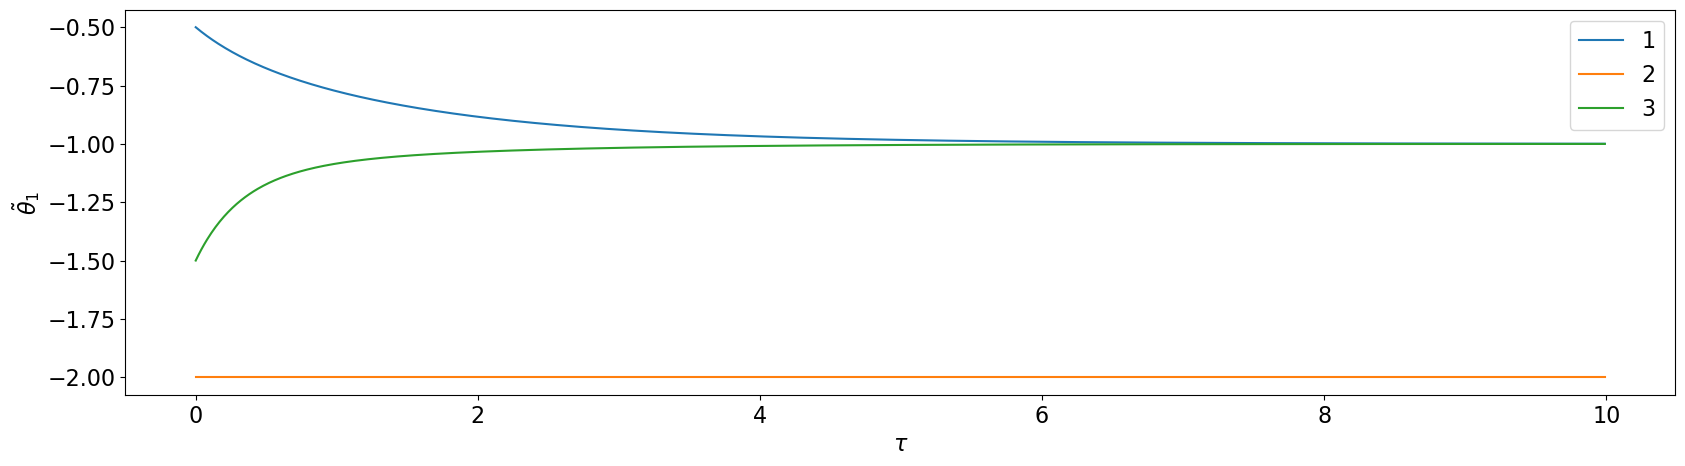

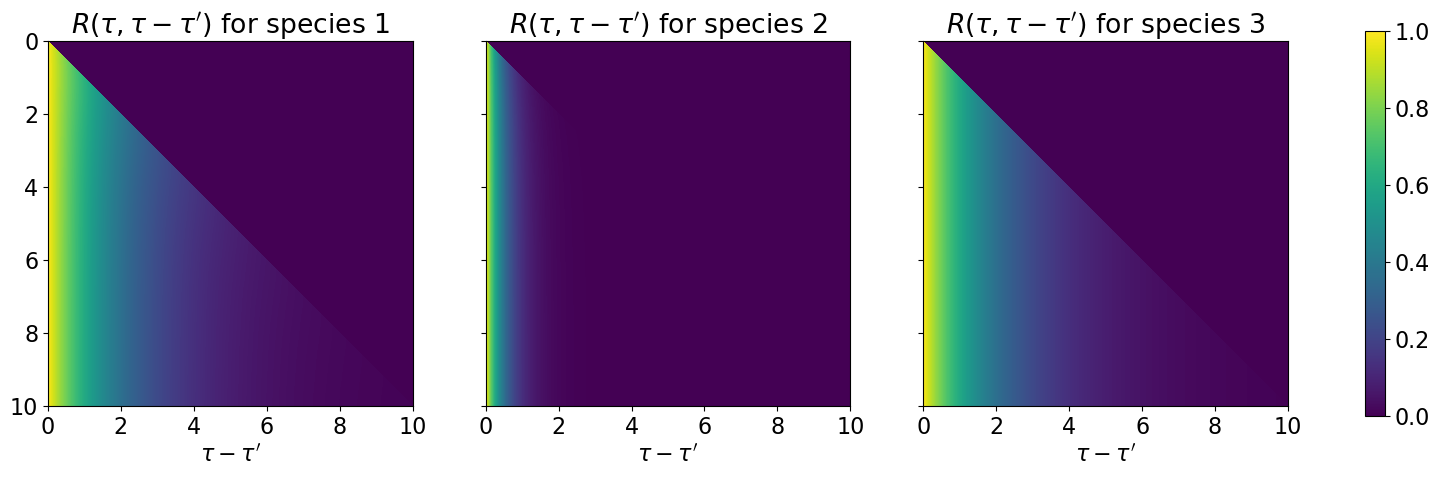

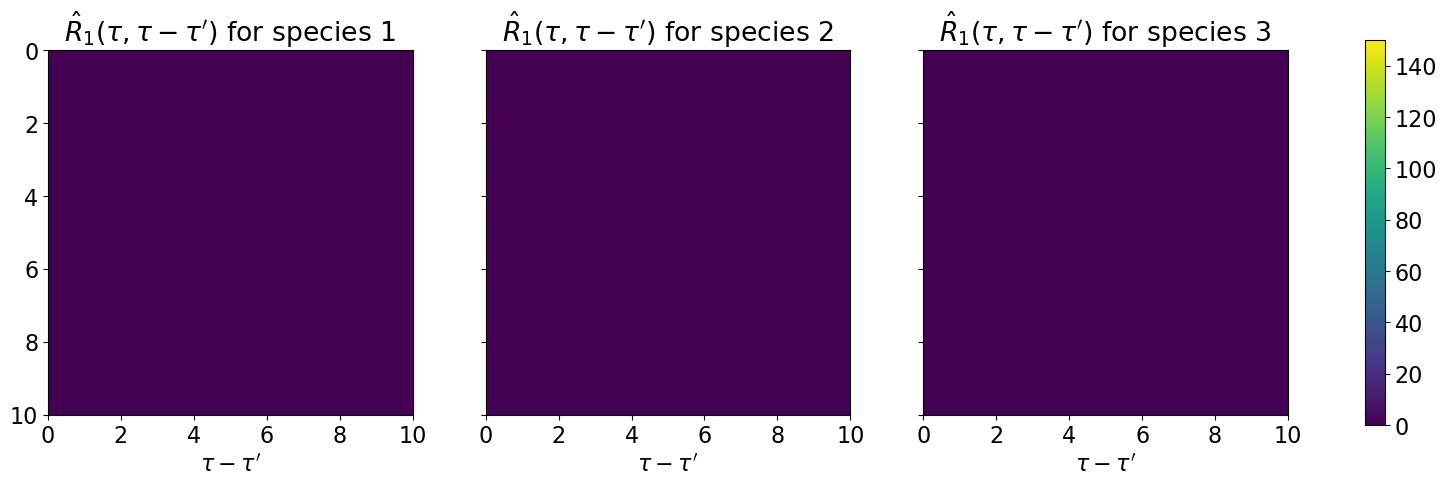

In [29]:
plf_sim_12 = Plefka(1.0, 1, "quad") # α, alphaOrder, orderParameter
res_plf_12 = euler_step(x0, k, tspan, plf_sim_12; ABC=false)
plot_trajectories_and_deviation(res_plf_12[1], res_gil)
plot_hatTheta(plf_sim_12, res_plf_12[3])
plot_responses(res_plf_12[2])
plot_hatR(plf_sim_12, tspan, res_plf_12[3].hatR1)

## Plefka with quad O.P. and power α²

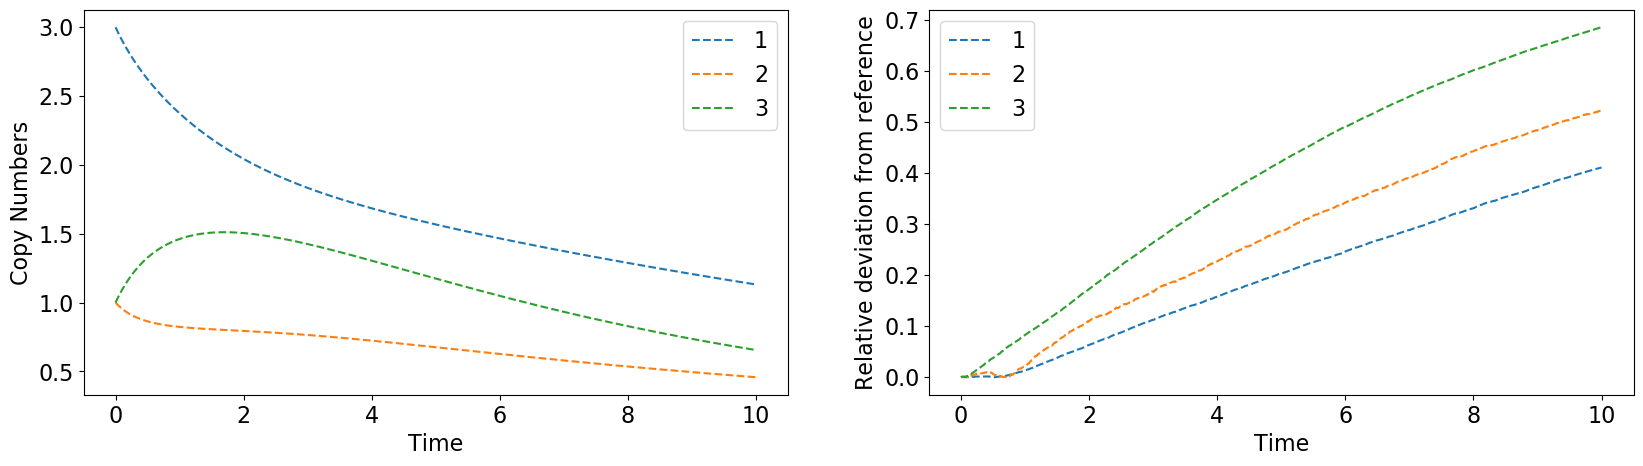

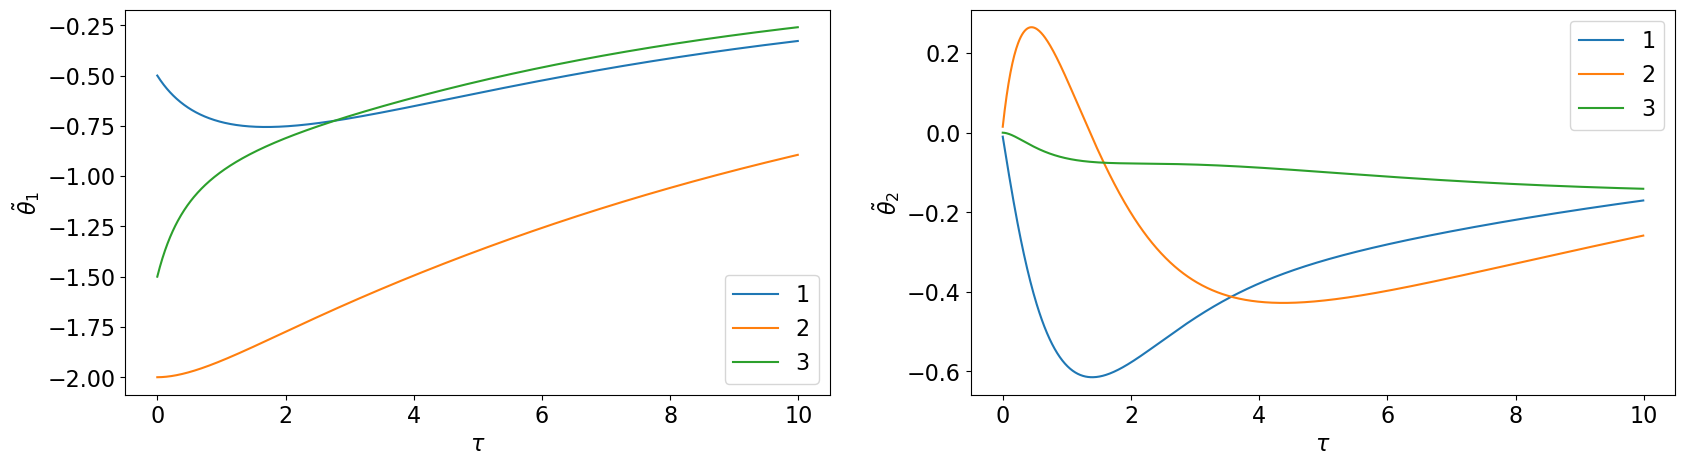

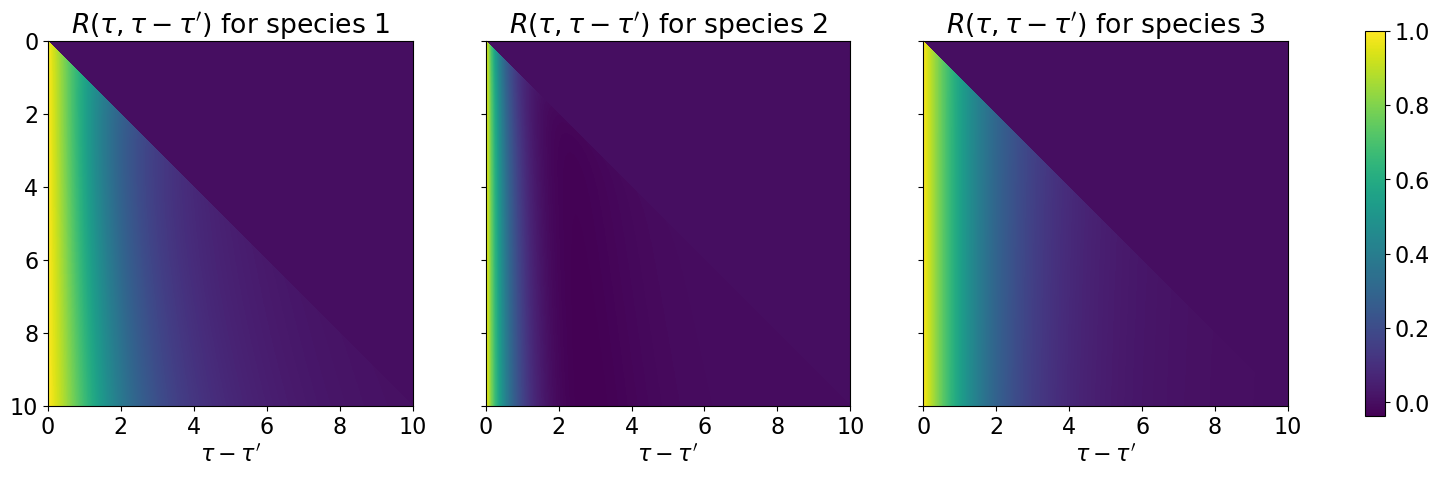

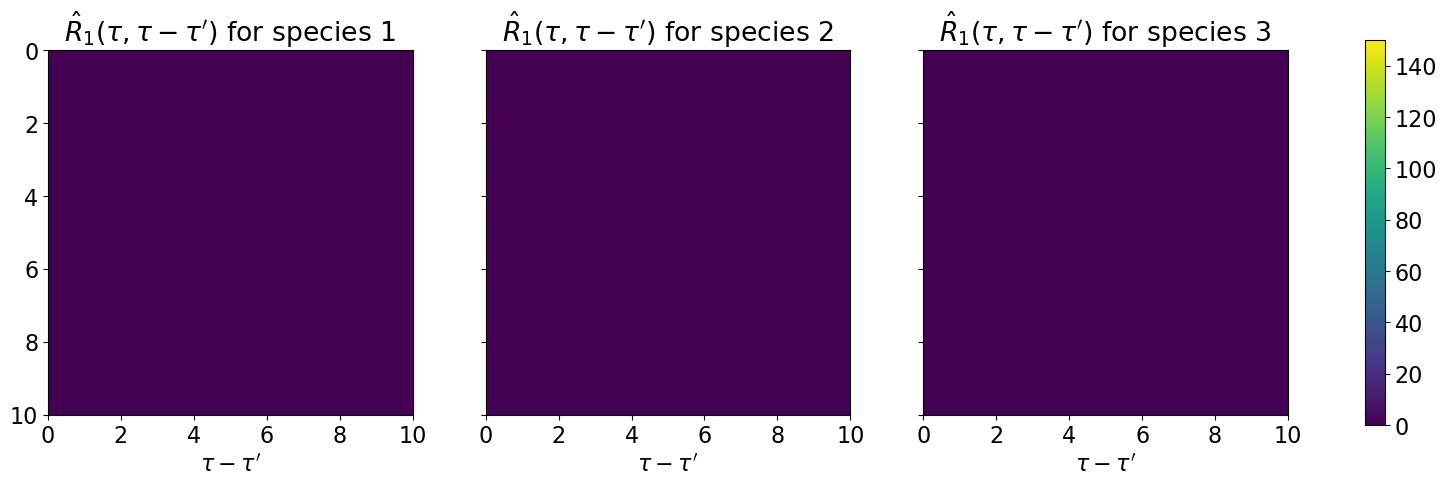

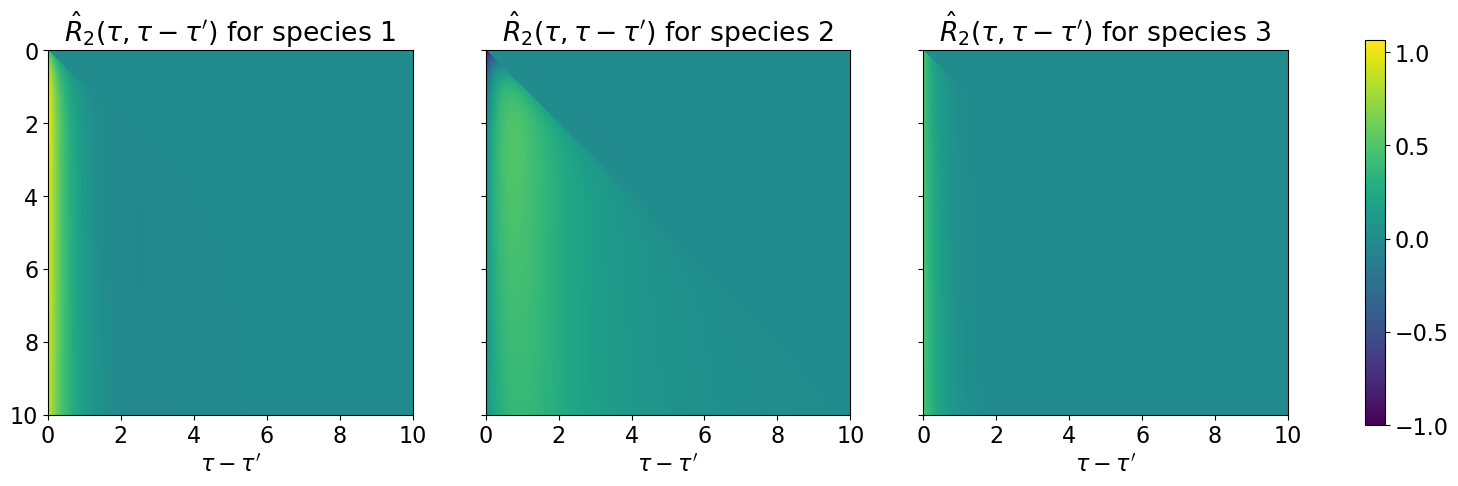

In [30]:
plf_sim_22 = Plefka(1.0, 2, "quad") # α, alphaOrder, orderParameter
res_plf_22 = euler_step(x0, k, tspan, plf_sim_22; ABC=false)
plot_trajectories_and_deviation(res_plf_22[1], res_gil)
plot_hatTheta(plf_sim_22, res_plf_22[3])
plot_responses(res_plf_22[2])
plot_hatR(plf_sim_22, tspan, res_plf_22[3].hatR1)
plot_hatR(plf_sim_22, tspan, res_plf_22[3].hatR2, quadR=true)

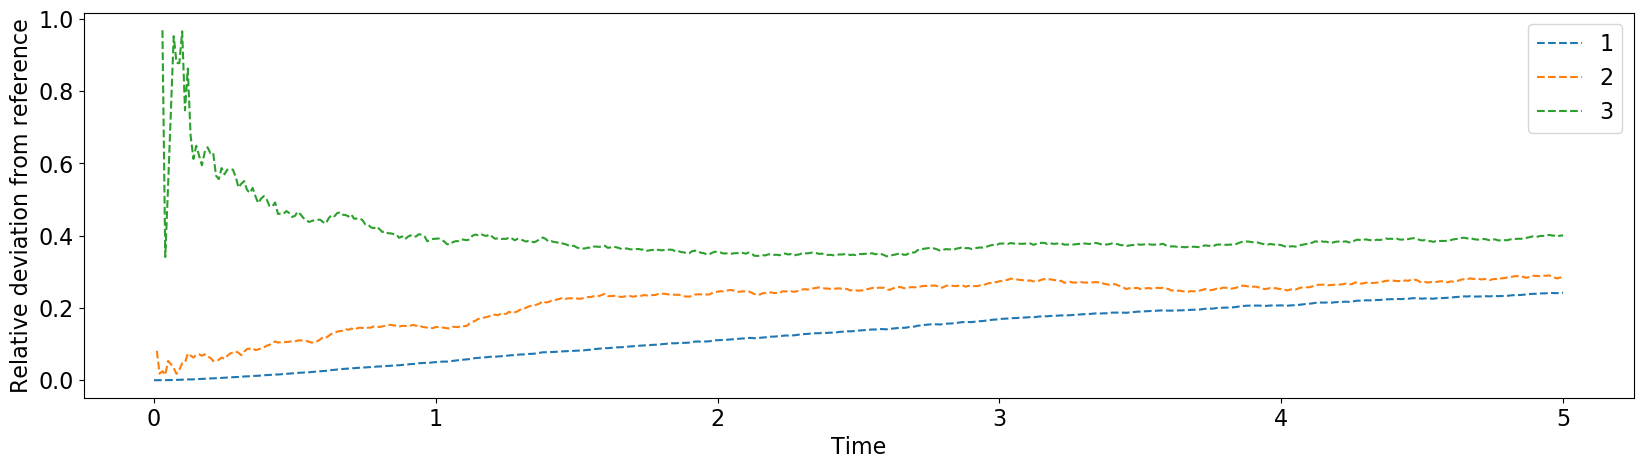

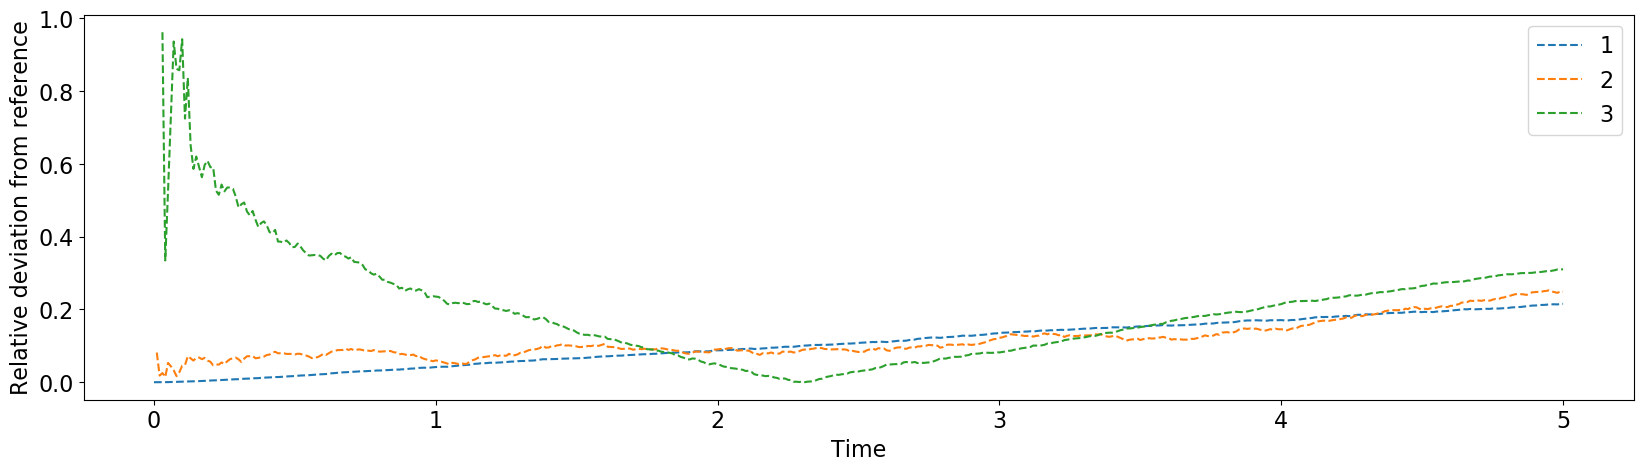

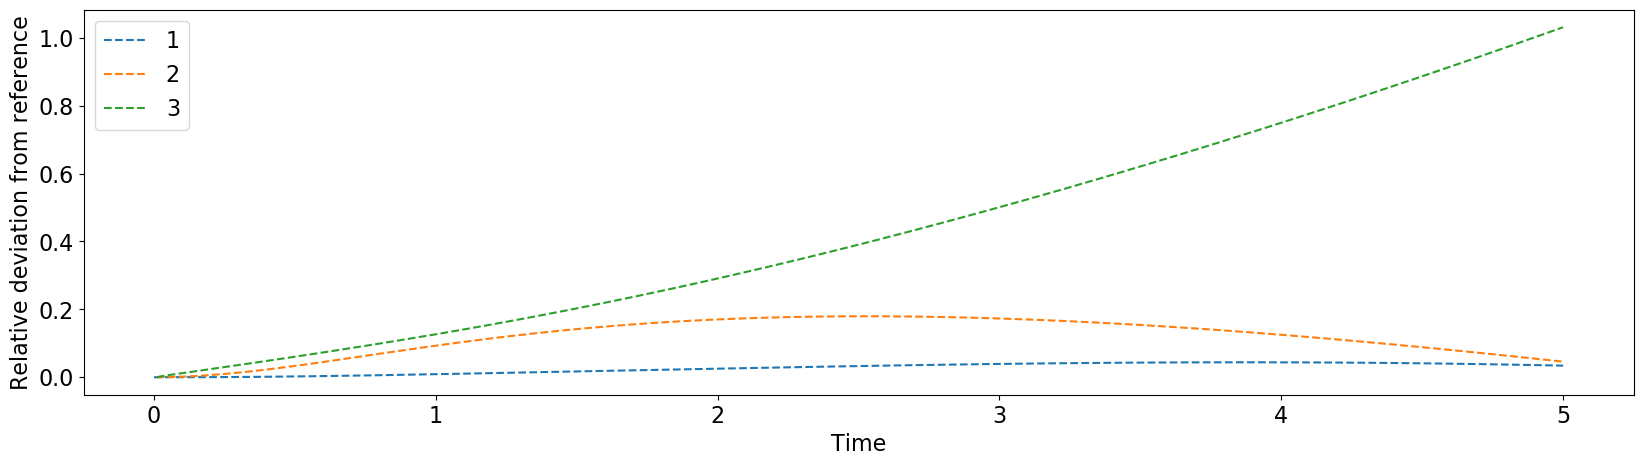

PyObject Text(32.999999999999986, 0.5, 'Relative deviation from reference')

In [9]:
plot_deviation(res_plf_21[1], res_gil)
plot_deviation(res_plf_22[1], res_gil)
plot_deviation(res_plf_21[1], res_plf_22[1])

In [10]:
# Comments:
# - (l.319) update hatR1 with y[:,self.i-1] for i=0 ???
# - (l.55) reaction prob vector with y[k,i]**r_i[m,k]
# - deviation first time step: large jump ???
# - ignore last time step for hatTheta ???

# TODOs
# - better arrangement of subplots

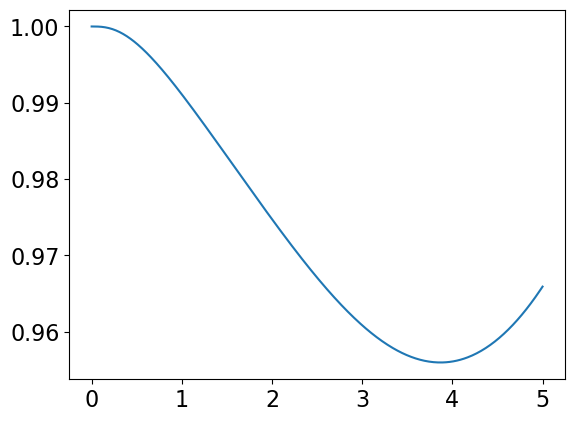

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2e45a48af0>

In [11]:
r = res_plf_21[1].data[1,:] ./ res_plf_22[1].data[1,:]
plot(tspan, r)

In [12]:
idx_species = 1
title = ["GIL" "lin-1" "quad-1" "lin-2" "quad-2"]
[ title; res_gil.data[idx_species,:] res_plf_11[1].data[idx_species,:] res_plf_12[1].data[idx_species,:] res_plf_21[1].data[idx_species,:] res_plf_22[1].data[idx_species,:] ]

502×5 Array{Any,2}:
  "GIL"   "lin-1"   "quad-1"   "lin-2"   "quad-2"
 2.0     2.0       2.0        2.0       2.0
 2.0     2.0       2.0        1.99995   1.99995
 2.0     1.9999    1.9999     1.99975   1.99975
 1.9997  1.9997    1.9997     1.99941   1.99941
 1.9992  1.99941   1.99941    1.99893   1.99893
 1.9989  1.99902   1.99902    1.99831   1.99832
 1.9986  1.99855   1.99855    1.99756   1.99758
 1.9983  1.99799   1.99799    1.99668   1.99671
 1.9977  1.99734   1.99734    1.99568   1.99572
 1.9971  1.99661   1.99661    1.99456   1.99461
 1.9966  1.99579   1.99579    1.99332   1.99339
 1.9954  1.9949    1.9949     1.99196   1.99206
 ⋮                                      
 1.2496  1.28706   1.28706    0.951026  0.986506
 1.249   1.28674   1.28674    0.950409  0.985701
 1.2484  1.28643   1.28643    0.949795  0.984897
 1.2491  1.28612   1.28612    0.949184  0.984095
 1.2486  1.28581   1.28581    0.948577  0.983295
 1.2481  1.2855    1.2855     0.947972  0.982496
 1.2493  1.28519   1.28

In [13]:
plot_responses(Responses(tspan, log.(res_plf_21[2].data .+ 1e-3)))
plot_responses(Responses(tspan, log.(res_plf_22[2].data .+ 1e-3)))

DomainError: DomainError with -0.0006289290047996909:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [14]:
res_plf_22[3].hatTheta2

3×501 Array{Float64,2}:
 -0.02  -0.0393998  -0.0582113  -0.0764466  …  -0.139161  -0.138889  0.0
  0.01   0.0196013   0.0288165   0.037658      -0.137575  -0.137444  0.0
 -0.01  -0.0196995  -0.0291047  -0.0382217     -0.134275  -0.134299  0.0